<a href="https://colab.research.google.com/github/henrykhlai/LSTM-rescale-precidtion/blob/main/LSTM_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#import the python library
%matplotlib inline
from pandas_datareader import data as web
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [4]:
#Get the stock symbols
#FAANG
assets =['FB','AMZN','AAPL','NFLX','GOOG','NKE','TSLA']
#stock start date
stockStartDate = '2000-01-01'
#stock end date
stockEndDate = datetime.today().strftime('%Y-%m-%d')
#stockEndDate = '2018-12-31'
#Create a dataframe to store the adjusted close price of the stocks
df = pd.DataFrame()

#store the adjust the close price
for stock in assets:
    df[stock] = web.DataReader(stock, data_source='yahoo', start = stockStartDate, end=stockEndDate)['Adj Close']
df

,FB,AMZN,AAPL,NFLX,GOOG,NKE,TSLA
Date,,,,,,,
2012-05-18,38.230000,213.850006,16.288403,9.994286,299.078979,23.707829,5.512000
2012-05-21,34.029999,218.110001,17.237370,10.248571,305.908386,24.110306,5.754000
2012-05-22,31.000000,215.330002,17.105009,9.672857,299.278229,24.384619,6.160000
2012-05-23,32.000000,217.279999,17.522364,10.272857,303.592072,24.175510,6.204000
2012-05-24,33.029999,215.240005,17.361441,10.038571,300.702881,24.166521,6.056000
...,...,...,...,...,...,...,...
2021-05-17,315.459991,3270.389893,126.269997,488.940002,2321.409912,136.410004,576.830017
2021-05-18,309.959991,3232.280029,124.849998,486.279999,2303.429932,135.559998,577.869995
2021-05-19,313.589996,3231.800049,124.690002,487.700012,2308.709961,132.960007,563.460022


In [5]:
data = df['AAPL'].values

In [6]:
timeseries_data = data[:-5]

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# scale and revert scale of input
def rescale(x,a,b):
    z = (x-a)/(b-a)
    return z

def revertscale(z,a,b):
    x = z*(b-a)+a
    return x

# preparing independent and dependent features
def prepare_data(timeseries_data, n_features):
    X, y =[],[]
    for i in range(len(timeseries_data)-n_features):        
        # find the end of this pattern
        end_ix = i + n_features
        # gather input and output parts of the pattern
        seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def LSTM_predict(timeseries_data, n_steps, n_features=1, predict_steps=20):
    
    # split into samples
    X, y = prepare_data(timeseries_data, n_steps)

    # reshape from [samples, timesteps] into [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], n_features))

    # define model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # fit model
    model.fit(X, y, epochs=200, verbose=0) # vervose = 0 make training Epoch not show

    # Prediction
    x_input = []
    x_input = timeseries_data[-(n_steps):]
    
    '''for i in range(n_steps,0,-1):
        x_input.append(timeseries_data[-i])
    x_input = np.array(x_input) # matrix'''

    x_input = x_input.reshape((1, n_steps, n_features)) # tensor
    yhat = model.predict(x_input, verbose=0)


    predict_output = []
    predict_output.append(yhat)
    x_input = x_input[0]

    xx_input = np.append(x_input[-(n_steps-1):],yhat[0])
    xx_input = xx_input.reshape(n_steps,n_features) #matrix
    #xx_input = np.array([x_input[-2],x_input[-1],yhat[0]]) # matrix
    #print(xx_input.shape)

    for i in range(predict_steps):
        xx_input = xx_input.reshape((1, n_steps, n_features)) # tensor
        # LSTM model only accept tensor as input
        yhat = model.predict(xx_input, verbose=0)

        xx_input = xx_input[0]

        xx_input = np.append(xx_input[-(n_steps-1):],yhat[0])
        xx_input = xx_input.reshape(n_steps,n_features) #matrix

        predict_output.append(yhat[0,0])

    predict_output = np.array(predict_output, dtype=np.float32)
    return predict_output

## AAPL

In [56]:
data = df['AAPL'].values

8


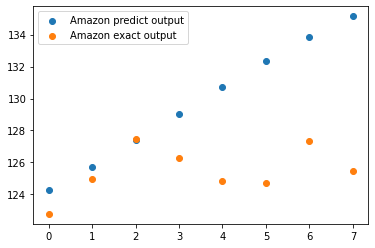

% error:
 [ 1.23741363  0.59391695 -0.05344467  2.18715962  4.69218463  6.16133712
  5.13339425  7.75230544]


In [57]:
# define input sequence
date_ahead = 7
timeseries_data = data[:-date_ahead]
test_data = data[-(date_ahead+1):]
a = np.min(timeseries_data)
b = np.max(timeseries_data)

XX = rescale(timeseries_data,a,b)
yy = LSTM_predict(XX, 14, 1, date_ahead)
predict_output = revertscale(yy,a,b)

import matplotlib.pyplot as plt
exact_output = test_data
print(len(exact_output))
plt.scatter(range(0,(date_ahead+1)),predict_output, label ='Apple predict output')
plt.scatter(range(0,(date_ahead+1)), exact_output, label = 'Apple exact output')
plt.legend()
plt.show()    
print('% error:\n', (predict_output - exact_output)/exact_output * 100) 

8


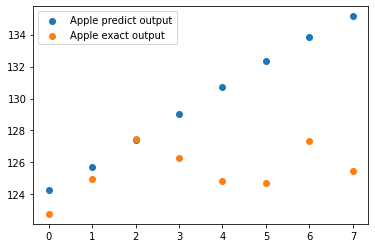

% error:
 [ 1.23741363  0.59391695 -0.05344467  2.18715962  4.69218463  6.16133712
  5.13339425  7.75230544]


In [58]:
import matplotlib.pyplot as plt
exact_output = test_data
print(len(exact_output))
plt.scatter(range(0,(date_ahead+1)),predict_output, label ='Apple predict output')
plt.scatter(range(0,(date_ahead+1)), exact_output, label = 'Apple exact output')
plt.legend()
plt.show()    
print('% error:\n', (predict_output - exact_output)/exact_output * 100) 

## Steps 14 business days

8


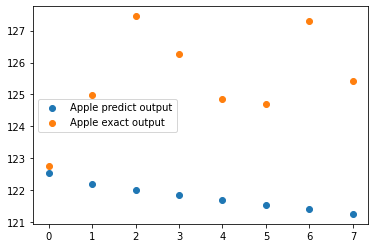

% error:
 [-0.19594563 -2.22872091 -4.26759427 -3.50133449 -2.52847365 -2.52338441
 -4.64374904 -3.32717755]


In [59]:
# define input sequence
date_ahead = 7
timeseries_data = data[:-date_ahead]
test_data = data[-(date_ahead+1):]
a = np.min(timeseries_data)
b = np.max(timeseries_data)

XX = rescale(timeseries_data,a,b)
yy = LSTM_predict(XX, 14, 1, date_ahead)
predict_output = revertscale(yy,a,b)

import matplotlib.pyplot as plt
exact_output = test_data
print(len(exact_output))
plt.scatter(range(0,(date_ahead+1)),predict_output, label ='Apple predict output')
plt.scatter(range(0,(date_ahead+1)), exact_output, label = 'Apple exact output')
plt.legend()
plt.show()    
print('% error:\n', (predict_output - exact_output)/exact_output * 100) 

8


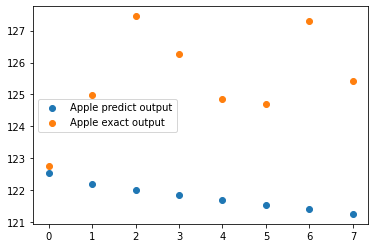

% error:
 [-0.19594563 -2.22872091 -4.26759427 -3.50133449 -2.52847365 -2.52338441
 -4.64374904 -3.32717755]


In [60]:
import matplotlib.pyplot as plt
exact_output = test_data
print(len(exact_output))
plt.scatter(range(0,(date_ahead+1)),predict_output, label ='Apple predict output')
plt.scatter(range(0,(date_ahead+1)), exact_output, label = 'Apple exact output')
plt.legend()
plt.show()    
print('% error:\n', (predict_output - exact_output)/exact_output * 100) 

## Amazon

In [8]:
amazon = df['AMZN'].values

In [53]:
# define input sequence
date_ahead = 7
timeseries_data = amazon[:-date_ahead]
test_data = amazon[-(date_ahead+1):]
a = np.min(timeseries_data)
b = np.max(timeseries_data)

XX = rescale(timeseries_data,a,b)
yy = LSTM_predict(XX, 14, 1, date_ahead)
predict_output = revertscale(yy,a,b)

8


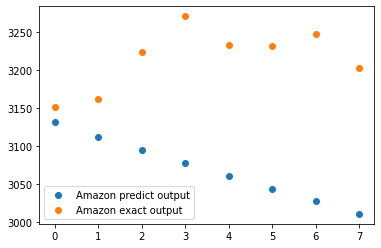

% error:
 [-0.64686105 -1.57155002 -3.9875167  -5.90131758 -5.31056537 -5.81089882
 -6.78138097 -5.99577768]


In [54]:
import matplotlib.pyplot as plt
exact_output = test_data
print(len(exact_output))
plt.scatter(range(0,(date_ahead+1)),predict_output, label ='Amazon predict output')
plt.scatter(range(0,(date_ahead+1)), exact_output, label = 'Amazon exact output')
plt.legend()
plt.show()    
print('% error:\n', (predict_output - exact_output)/exact_output * 100) 

7 days steps

In [51]:
# define input sequence
date_ahead = 7
timeseries_data = amazon[:-date_ahead]
test_data = amazon[-(date_ahead+1):]
a = np.min(timeseries_data)
b = np.max(timeseries_data)

XX = rescale(timeseries_data,a,b)
yy = LSTM_predict(XX, 7, 1, date_ahead)
predict_output = revertscale(yy,a,b)


8


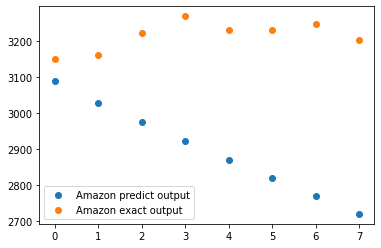

% error:
 [ -2.00198353  -4.1724311   -7.7094853  -10.65162323 -11.21577163
 -12.78381121 -14.75575601 -15.10628655]


In [52]:
import matplotlib.pyplot as plt
exact_output = test_data
print(len(exact_output))
plt.scatter(range(0,(date_ahead+1)),predict_output, label ='Amazon predict output')
plt.scatter(range(0,(date_ahead+1)), exact_output, label = 'Amazon exact output')
plt.legend()
plt.show()    
print('% error:\n', (predict_output - exact_output)/exact_output * 100) 

## Future Prediction

In [18]:
# define input sequence
timeseries_data = amazon[:]
a = np.min(timeseries_data)
b = np.max(timeseries_data)
date_ahead = 5
XX = rescale(timeseries_data,a,b)
yy = LSTM_predict(XX, 14,1,date_ahead)
predict_output = revertscale(yy,a,b)

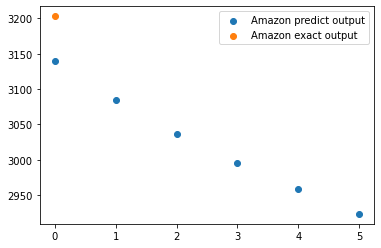

In [39]:
import matplotlib.pyplot as plt
exact_output = timeseries_data = amazon[-1:]
plt.scatter(range(0,date_ahead+1),predict_output, label ='Amazon predict output')

plt.scatter(range(0,1), exact_output, label = 'Amazon exact output')
plt.legend()
plt.show()    
print('% error:\n', (predict_output[0] - exact_output[0])/exact_output * 100) 

In [37]:
len(predict_output)

6

In [48]:
test_data

array([], dtype=float64)